#### Motivaçao:
 - Download da base de dados
 - Manipulaçao dos dados
 - Desenvolvimento do modelo
 - Avaliaçao do modelo
 - Conclusoes
 
 
 Esta aula é baseada na base de dados a seguir:
 Adult Data Set: https://archive.ics.uci.edu/ml/datasets/adult
 Donor:
 Ronny Kohavi and Barry Becker
 Data Mining and Visualization
 Silicon Graphics.

In [1]:
options(warn = -1) 

In [ ]:
#install.packages("xgboost")

In [2]:
# Carregando as bibliotecas

library(data.table)
library(xgboost)
library(ggplot2)
library(dplyr)
library(stringr)
library(caret)


Attaching package: 'dplyr'

The following object is masked from 'package:xgboost':

    slice

The following objects are masked from 'package:data.table':

    between, first, last

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: lattice


_____________________________________________

### Download da base de dados

In [3]:
colunas <- c("age", "workclass", "fnlwgt", "education", "education_num", "marital_status", "occupation", "relationship"
            , "race", "sex", "capital_gain", "capital-loss", "hours_per_week", "native_country", "target")

adult_train <- read.csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
                          , header = F, sep = ",", col.names = colunas, na.strings = c(" ?"), stringsAsFactors = F)
adult_test <- read.csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"
                         , header = F, sep = ",", col.names = colunas, na.strings = c(" ?"), stringsAsFactors = F)

# Observaçao: no arquivo original, os dados faltantes estao como " ?"

In [4]:
str(adult_train)
str(adult_test)

'data.frame':	32561 obs. of  15 variables:
 $ age           : int  39 50 38 53 28 37 49 52 31 42 ...
 $ workclass     : chr  " State-gov" " Self-emp-not-inc" " Private" " Private" ...
 $ fnlwgt        : int  77516 83311 215646 234721 338409 284582 160187 209642 45781 159449 ...
 $ education     : chr  " Bachelors" " Bachelors" " HS-grad" " 11th" ...
 $ education_num : int  13 13 9 7 13 14 5 9 14 13 ...
 $ marital_status: chr  " Never-married" " Married-civ-spouse" " Divorced" " Married-civ-spouse" ...
 $ occupation    : chr  " Adm-clerical" " Exec-managerial" " Handlers-cleaners" " Handlers-cleaners" ...
 $ relationship  : chr  " Not-in-family" " Husband" " Not-in-family" " Husband" ...
 $ race          : chr  " White" " White" " White" " Black" ...
 $ sex           : chr  " Male" " Male" " Male" " Male" ...
 $ capital_gain  : int  2174 0 0 0 0 0 0 0 14084 5178 ...
 $ capital.loss  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ hours_per_week: int  40 13 40 40 40 40 16 45 50 40 ...
 $ native_countr

_____________________________________________

### Manipulaçao dos dados

In [16]:
# Temos um problema na primeira linha do teste

head(adult_test)

age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital.loss,hours_per_week,native_country,target
39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [6]:
adult_test <- adult_test[-c(1), ] 

In [8]:
# Verificando dados faltantes - base de treinamento

table(is.na(adult_train))


 FALSE   TRUE 
484153   4262 

In [9]:
# Verifica onde temos NAs e qual o percentual - base de treinamento

print("% de dados faltantes - base de treinamento")
round(sapply(adult_train, function(x) sum(is.na(x))/length(x))*100, 2)

[1] "% de dados faltantes - base de treinamento"


age      workclass         fnlwgt      education  education_num 
          0.00           5.64           0.00           0.00           0.00 
marital_status     occupation   relationship           race            sex 
          0.00           5.66           0.00           0.00           0.00 
  capital_gain   capital.loss hours_per_week native_country         target 
          0.00           0.00           0.00           1.79           0.00

In [10]:
# Verificando dados faltantes - base de treinamento

table(is.na(adult_test))


 FALSE   TRUE 
242012   2203 

In [11]:
# Verifica onde temos NAs e qual o percentual - base de treinamento

print("% de dados faltantes - base de teste")
round(sapply(adult_test, function(x) sum(is.na(x))/length(x))*100, 2)

[1] "% de dados faltantes - base de teste"


age      workclass         fnlwgt      education  education_num 
          0.00           5.91           0.00           0.00           0.00 
marital_status     occupation   relationship           race            sex 
          0.00           5.93           0.00           0.00           0.00 
  capital_gain   capital.loss hours_per_week native_country         target 
          0.00           0.00           0.00           1.68           0.00

In [12]:
# Desta vez vamos usar os dados faltantes como informaçao ùtil

adult_train[is.na(adult_train)] <- "Ausente" 
adult_test[is.na(adult_test)] <- "Ausente"

In [13]:
# Ajustando o alvo - possui um espaço em branco e um ponto

table(adult_train$target)
table(adult_test$target)


 <=50K   >50K 
 24720   7841 


 <=50K.   >50K. 
  12435    3846 

In [14]:
adult_test$target <- gsub(".", "", adult_test$target, fixed = TRUE)

adult_train <- adult_train %>% mutate(across(where(is.character), str_trim))
adult_test <- adult_test %>% mutate(across(where(is.character), str_trim))

In [15]:
# Agora nao mais
str(adult_test$target)

 chr [1:16281] "<=50K" "<=50K" ">50K" ">50K" "<=50K" "<=50K" "<=50K" ">50K" ...


In [19]:
# Mais um outro problema

summary(adult_train$age)
summary(adult_test$age)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  17.00   28.00   37.00   38.58   48.00   90.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  17.00   28.00   37.00   38.77   48.00   90.00 

In [18]:
adult_test$age <- as.numeric(adult_test$age)

In [20]:
# Atençao: O XGBoost só funciona com vetores numéricos. Logo, precisamos transformar todos os dados e variaveis - usando 
# one hot encoding

# Criando a matriz das variaveis - aqui acontece o one hot enconding
treinamento <- model.matrix(~ .+0, data = subset(adult_train, select = -c(target))) 
teste <- model.matrix(~ .+0, data = subset(adult_test, select = -c(target))) 

In [21]:
str(treinamento)
str(teste)

 num [1:32561, 1:101] 39 50 38 53 28 37 49 52 31 42 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:32561] "1" "2" "3" "4" ...
  ..$ : chr [1:101] "age" "workclassAusente" "workclassFederal-gov" "workclassLocal-gov" ...
 - attr(*, "assign")= int [1:101] 1 2 2 2 2 2 2 2 2 2 ...
 - attr(*, "contrasts")=List of 8
  ..$ workclass     : chr "contr.treatment"
  ..$ education     : chr "contr.treatment"
  ..$ marital_status: chr "contr.treatment"
  ..$ occupation    : chr "contr.treatment"
  ..$ relationship  : chr "contr.treatment"
  ..$ race          : chr "contr.treatment"
  ..$ sex           : chr "contr.treatment"
  ..$ native_country: chr "contr.treatment"
 num [1:16281, 1:100] 25 38 28 44 18 34 29 63 24 55 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:16281] "1" "2" "3" "4" ...
  ..$ : chr [1:100] "age" "workclassAusente" "workclassFederal-gov" "workclassLocal-gov" ...
 - attr(*, "assign")= int [1:100] 1 2 2 2 2 2 2 2 2 2 ...
 - attr(*, "contrasts")=List of 8
  ..$ workclass 

In [23]:
# Ajustando o alvo para numerico
table(adult_train$target)


<=50K  >50K 
24720  7841 

In [22]:
alvo_train <- ifelse(adult_train$target == "<=50K", 0, 1)
alvo_test <- ifelse(adult_test$target == "<=50K", 0, 1)

In [24]:
# Ajustando o formato das bases para o desenvolvimento do modelo

treinamento <- xgb.DMatrix(data = treinamento, label = alvo_train) 
teste <- xgb.DMatrix(data = teste, label = alvo_test)

colnames(teste) <- NULL

In [25]:
treinamento
teste

xgb.DMatrix  dim: 32561 x 101  info: label  colnames: yes

xgb.DMatrix  dim: 16281 x 100  info: label  colnames: no

In [26]:
str(teste)

Class 'xgb.DMatrix' <externalptr> 


_____________________________________________

### Desenvolvimento do modelo

In [27]:
# Definiçao dos hiper parametros

hiper_p <- list(booster = "gbtree", objective = "binary:logistic"
               , eta = 0.1, gamma = 0, max_depth = 10, min_child_weight = 1
               , subsample = 0.5, colsample_bytree = 1)

In [28]:
# Usando a funçao .cv para deterninar o melhor nùmero de repeticoes

set.seed(42)
best_nround <- xgb.cv(params = hiper_p, data = treinamento, nrounds = 100
                , nfold = 5, showsd = T, stratified = T
                , print.every.n = 10, early.stop.round = 20
                , maximize = F)

[21:19:52] WARNING: amalgamation/../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:19:52] WARNING: amalgamation/../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:19:52] WARNING: amalgamation/../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:19:52] WARNING: amalgamation/../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly

In [29]:
str(best_nround)

List of 9
 $ call           : language xgb.cv(params = hiper_p, data = treinamento, nrounds = 100, nfold = 5,      showsd = T, stratified = T, maximize | __truncated__
 $ params         :List of 11
  ..$ booster         : chr "gbtree"
  ..$ objective       : chr "binary:logistic"
  ..$ eta             : num 0.1
  ..$ gamma           : num 0
  ..$ max_depth       : num 10
  ..$ min_child_weight: num 1
  ..$ subsample       : num 0.5
  ..$ colsample_bytree: num 1
  ..$ print_every_n   : num 10
  ..$ early_stop_round: num 20
  ..$ silent          : num 1
 $ callbacks      :List of 3
  ..$ cb.print.evaluation:function (env = parent.frame())  
  .. ..- attr(*, "call")= language cb.print.evaluation(period = print_every_n, showsd = showsd)
  .. ..- attr(*, "name")= chr "cb.print.evaluation"
  ..$ cb.evaluation.log  :function (env = parent.frame(), finalize = FALSE)  
  .. ..- attr(*, "call")= language cb.evaluation.log()
  .. ..- attr(*, "name")= chr "cb.evaluation.log"
  ..$ cb.early.stop   

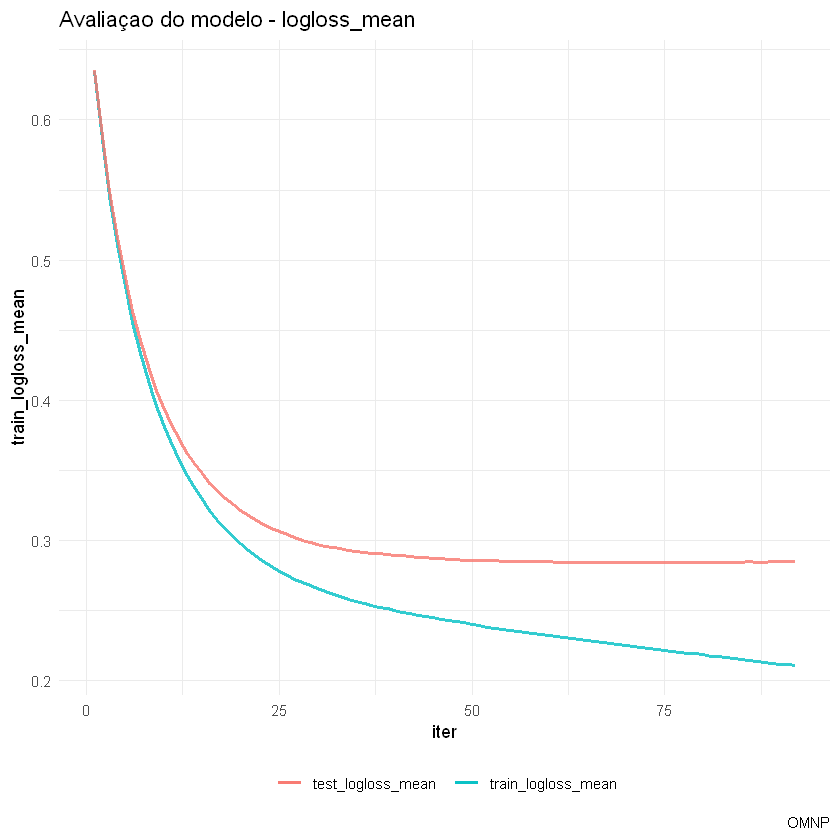

In [30]:
# Visualizaçao da log_loss - treinamento x teste

colors <- c("train_logloss_mean" = "darkblue"
           ,"test_logloss_mean " = "red")

ggplot(data = best_nround$evaluation_log, aes(x = iter)) +
geom_line(aes(y = train_logloss_mean, color = "train_logloss_mean"), size = 1, alpha = 0.8) +
geom_line(aes(y = test_logloss_mean , color = "test_logloss_mean"), size = 1, alpha = 0.8) +
theme_minimal() +
theme(legend.position = "bottom") +
ggtitle("Avaliaçao do modelo - logloss_mean") +
labs(caption = "OMNP", color = "") 

In [32]:
# Treinando o modelo

set.seed(42)
mod1 <-xgboost(data = treinamento
               , hiper_p
               , nrounds = best_nround$best_iteration
               , print.every.n = 10
               , eval_metric = "logloss")

[21:24:07] WARNING: amalgamation/../src/learner.cc:573: 
Parameters: { "print_every_n" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[1]	train-logloss:0.538294 
[11]	train-logloss:0.282970 
[21]	train-logloss:0.273257 
[31]	train-logloss:0.263059 
[41]	train-logloss:0.256426 
[51]	train-logloss:0.251347 
[61]	train-logloss:0.246602 
[71]	train-logloss:0.242217 
[72]	train-logloss:0.242023 


In [31]:
best_nround$best_iteration

[1] 72

In [33]:
# Previsao no treinamento e teste

y_pred_teste <- predict(mod1, teste)

In [34]:
y_pred_teste <- ifelse(y_pred_teste > 0.5, 1, 0)

_____________________________________________

### Avaliaçao dos modelo

In [35]:
# Matriz de confusao

confusionMatrix(as.factor(y_pred_teste), as.factor(alvo_test), positive = "1")

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 11850  1514
         1   585  2332
                                          
               Accuracy : 0.8711          
                 95% CI : (0.8658, 0.8762)
    No Information Rate : 0.7638          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6102          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.6063          
            Specificity : 0.9530          
         Pos Pred Value : 0.7995          
         Neg Pred Value : 0.8867          
             Prevalence : 0.2362          
         Detection Rate : 0.1432          
   Detection Prevalence : 0.1792          
      Balanced Accuracy : 0.7796          
                                          
       'Positive' Class : 1               
                  

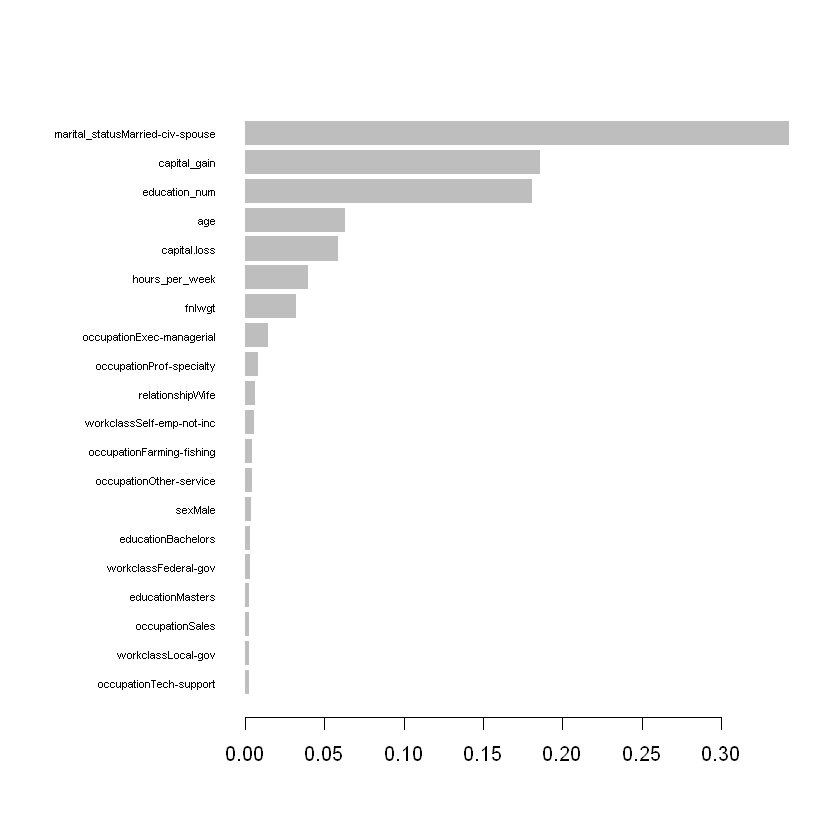

In [37]:
# Importancia das variaveis

important_vars <- xgb.importance(feature_names = colnames(teste), model = mod1)
xgb.plot.importance(importance_matrix = important_vars[1:20]) 